# QBUS2820 Assignment 1

**SID:** 510575452

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Loading in Dataset

In [2]:
heating_load_training_data = pd.read_csv('data/HeatingLoad_training.csv')
heating_load_test_without_HL_data = pd.read_csv(
    'data/HeatingLoad_test_without_HL.csv')

# EDA

## Looking at key characteristics of the dataset

In [3]:
heating_load_training_data.head()

,BuildingAge,BuildingHeight,Insulation,AverageTemperature,SunlightExposure,WindSpeed,OccupancyRate,HeatingLoad
0,18.56,30.36,1,13.75,453.67,3.89,0.65,275.89
1,13.82,9.64,0,18.70,138.85,0.95,0.55,208.02
2,36.47,8.44,1,18.23,190.31,4.71,0.56,234.86
3,23.23,18.71,1,21.89,313.15,8.51,0.25,243.89
4,11.62,11.95,0,19.49,117.53,1.57,0.58,205.94


In [4]:
heating_load_training_data.columns

Index(['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature',
       'SunlightExposure', 'WindSpeed', 'OccupancyRate', 'HeatingLoad'],
      dtype='object')

In [5]:
heating_load_training_data.shape

(10000, 8)

## Data Cleaning

### Removing null values

In [6]:
# drop nan values
heating_load_training_data = heating_load_training_data.dropna()


## Looking at the information of the dataset

In [7]:
heating_load_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BuildingAge         10000 non-null  float64
 1   BuildingHeight      10000 non-null  float64
 2   Insulation          10000 non-null  int64  
 3   AverageTemperature  10000 non-null  float64
 4   SunlightExposure    10000 non-null  float64
 5   WindSpeed           10000 non-null  float64
 6   OccupancyRate       10000 non-null  float64
 7   HeatingLoad         10000 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 625.1 KB


## Looking at the description of the dataset

In [8]:
heating_load_training_data.describe()

,BuildingAge,BuildingHeight,Insulation,AverageTemperature,SunlightExposure,WindSpeed,OccupancyRate,HeatingLoad
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,22.765466,20.792105,0.596000,18.024851,271.361610,4.490681,0.500124,260.078634
std,12.385964,16.882672,0.490722,4.090699,229.275176,2.531248,0.221971,74.591892
min,2.990000,3.070000,0.000000,1.680000,1.150000,0.070000,0.010000,173.680000
25%,14.250000,9.310000,0.000000,15.270000,100.082500,2.610000,0.330000,218.087500
50%,20.090000,15.020000,1.000000,18.020000,182.435000,4.100000,0.500000,236.800000
75%,28.092500,25.830000,1.000000,20.810000,407.090000,5.960000,0.670000,270.350000
max,153.880000,106.360000,1.000000,34.340000,1250.710000,18.910000,1.000000,793.920000


## Checking for null values

In [9]:
heating_load_training_data.isnull().sum()

BuildingAge           0
BuildingHeight        0
Insulation            0
AverageTemperature    0
SunlightExposure      0
WindSpeed             0
OccupancyRate         0
HeatingLoad           0
dtype: int64

## Checking for skewness

### Histogram

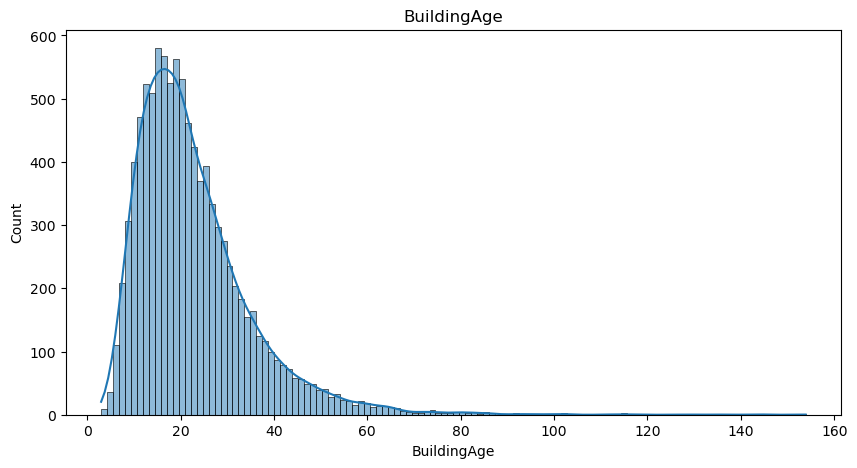

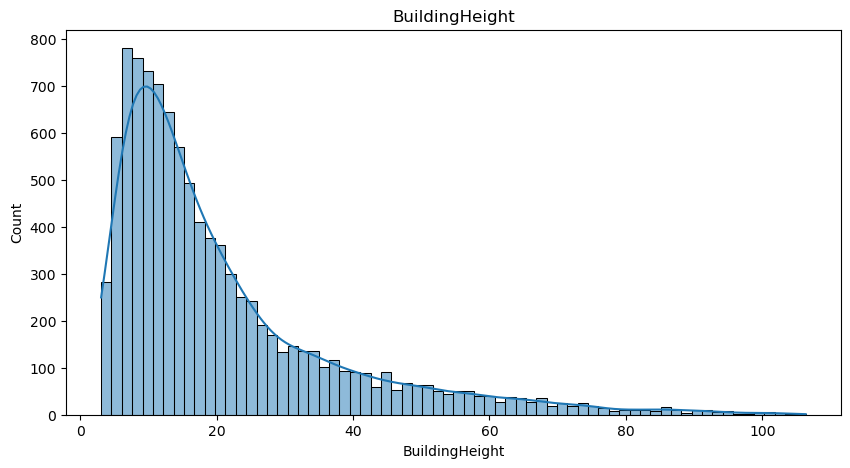

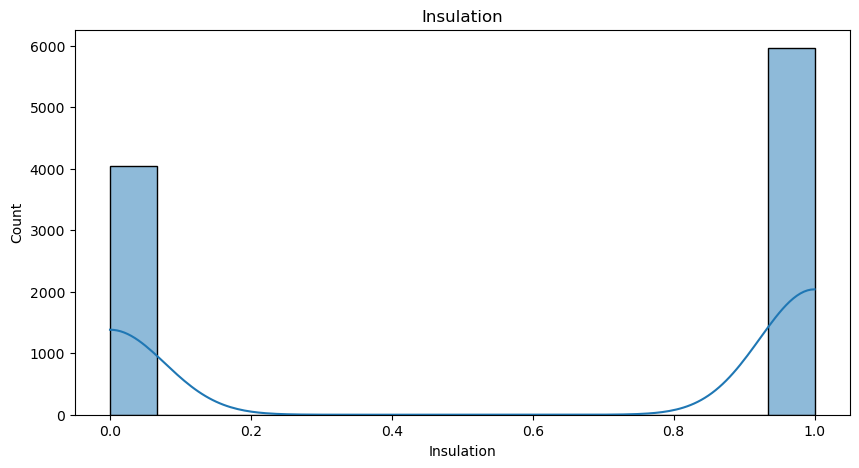

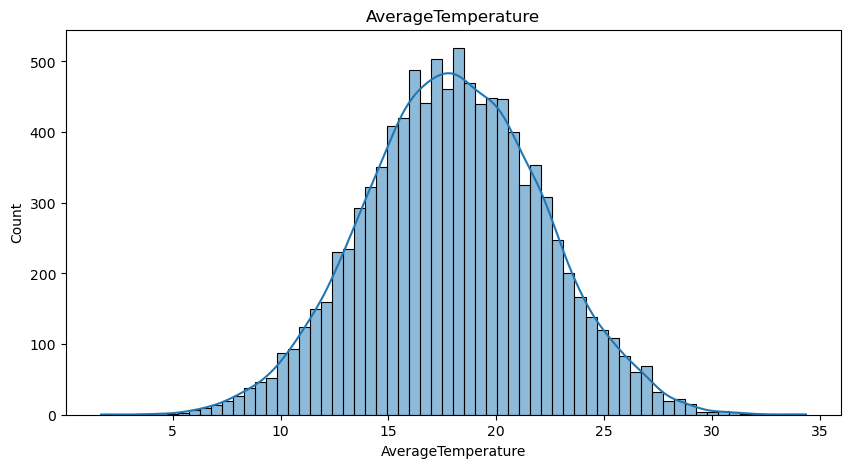

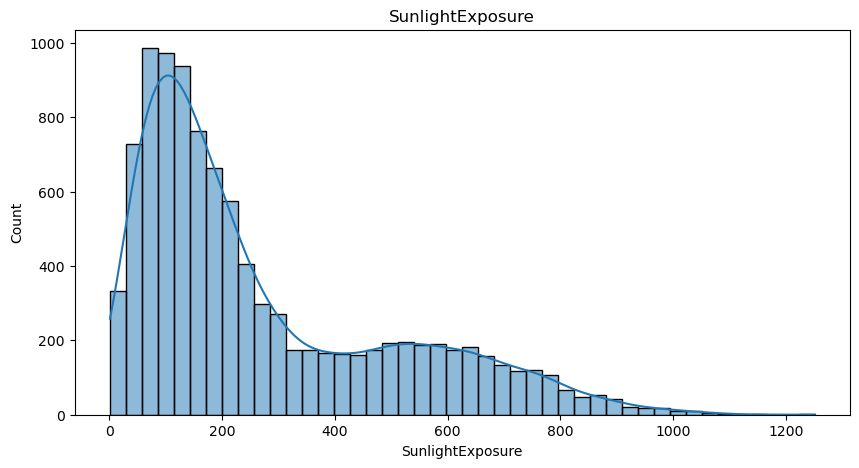

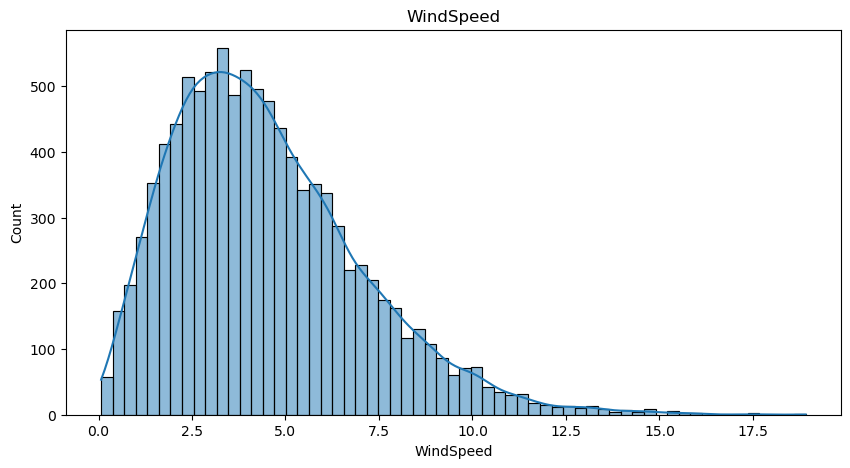

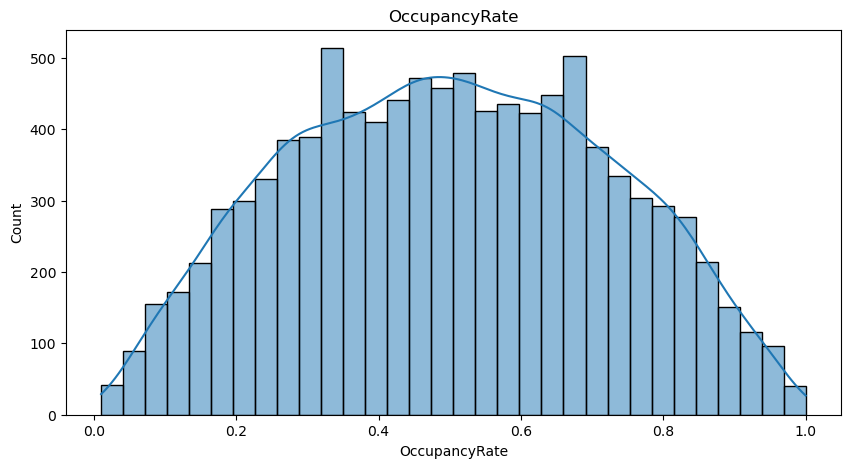

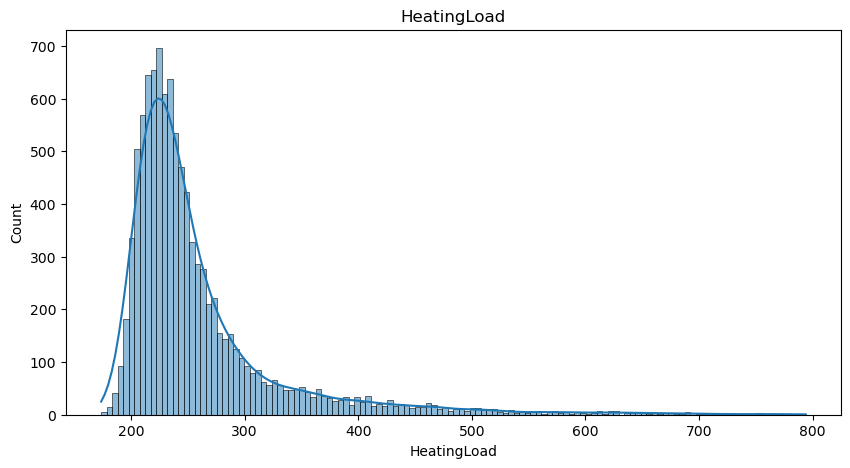

In [10]:
# Create a histogram of the variables with bell shaped distribution
for i in heating_load_training_data.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(heating_load_training_data[i], kde=True)
    plt.title(i)
    plt.show()

### QQ-plot

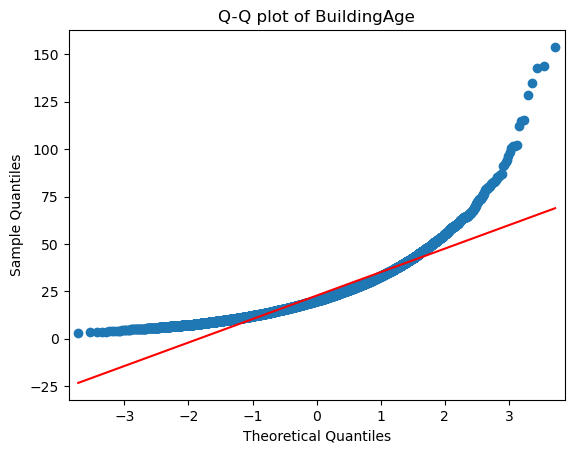

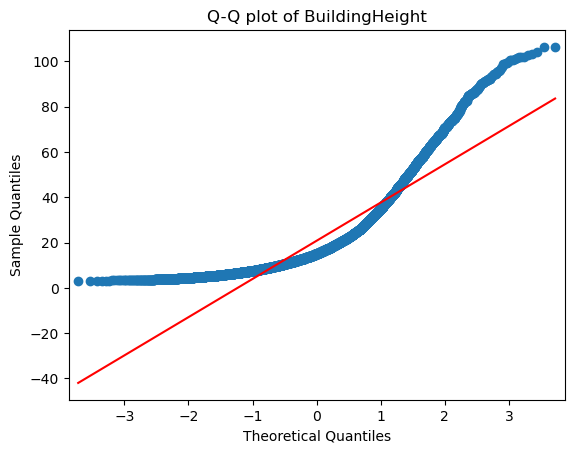

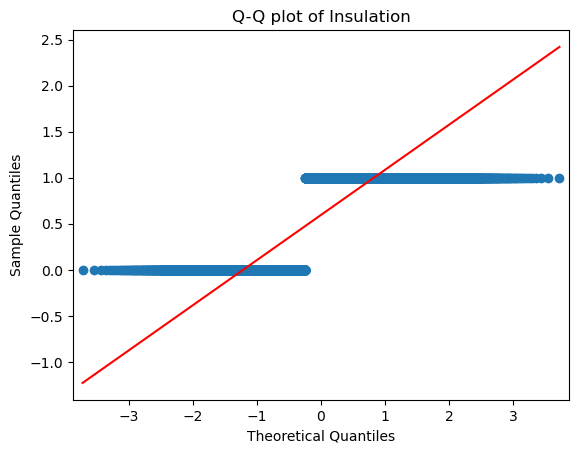

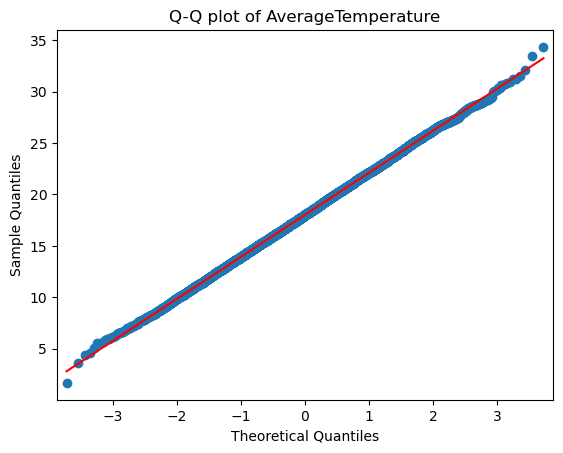

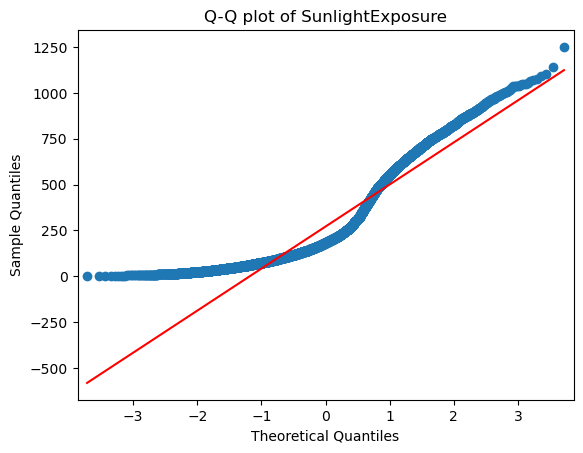

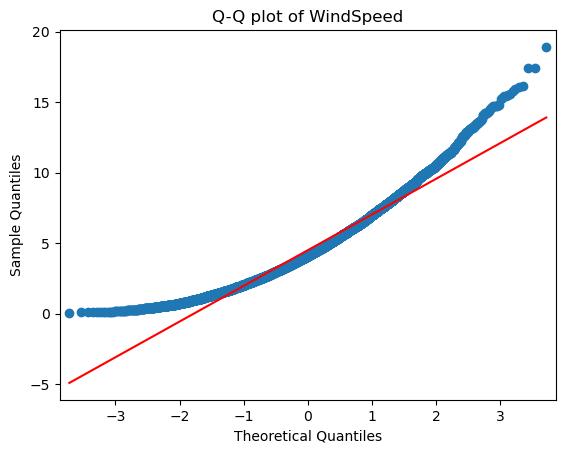

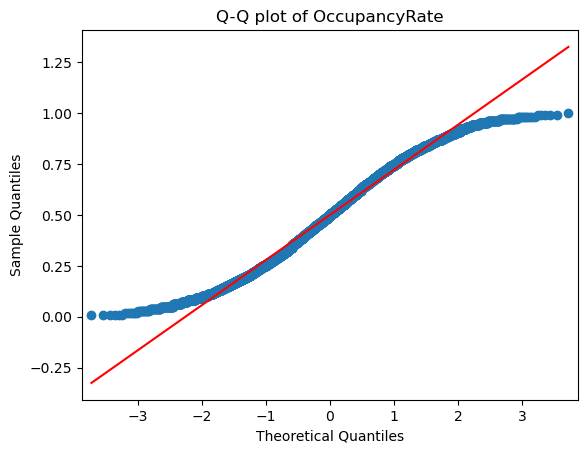

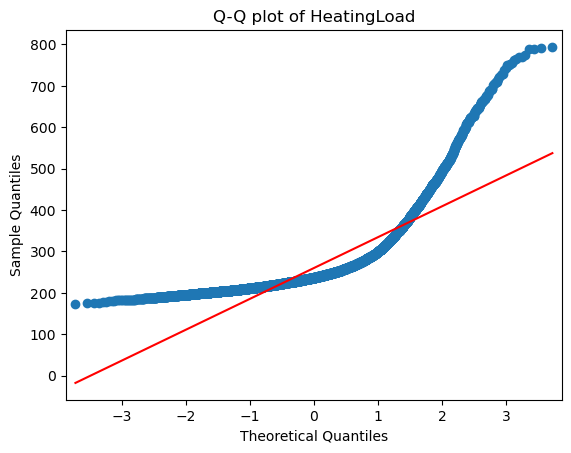

In [11]:
for i in heating_load_training_data.columns:
    sm.qqplot(heating_load_training_data[i], line='s')
    plt.title(f'Q-Q plot of {i}')
    plt.show()

### Residuels vs Fitted

# Data Preprocessing

## Log Transformation

In [12]:
# Apply log transofrmation to the variables to make them more normally distributed
log_transformed_heat_load_training_data = heating_load_training_data.copy()

# for i in log_transformed_heat_load_training_data.columns:
#     log_transformed_heat_load_training_data[i] = np.log(
#         log_transformed_heat_load_training_data[i]+10)

for i in log_transformed_heat_load_training_data.columns:
    if i not in ['Insulation','AverageTemperature']:
        log_transformed_heat_load_training_data[i] = np.log10(
            log_transformed_heat_load_training_data[i]+1)

# log_transformed_heat_load_training_data['BuildingAge'] = np.log(log_transformed_heat_load_training_data['BuildingAge']+10)
# log_transformed_heat_load_training_data['BuildingHeight'] = np.log(log_transformed_heat_load_training_data['BuildingHeight']+10)
# log_transformed_heat_load_training_data['SunlightExposure'] = np.log(log_transformed_heat_load_training_data['SunlightExposure']+10)
# log_transformed_heat_load_training_data['WindSpeed'] = np.log(log_transformed_heat_load_training_data['WindSpeed']+10)
# log_transformed_heat_load_training_data['OccupancyRate'] = np.log(log_transformed_heat_load_training_data['OccupancyRate']+10)
# log_transformed_heat_load_training_data['HeatingLoad'] = np.log(log_transformed_heat_load_training_data['HeatingLoad']+10)

log_transformed_heat_load_training_data.head()

,BuildingAge,BuildingHeight,Insulation,AverageTemperature,SunlightExposure,WindSpeed,OccupancyRate,HeatingLoad
0,1.291369,1.496376,1,13.75,2.657696,0.689309,0.217484,2.442307
1,1.170848,1.026942,0,18.70,2.145662,0.290035,0.190332,2.320188
2,1.573684,0.974972,1,18.23,2.281738,0.756636,0.193125,2.372654
3,1.384353,1.294687,1,21.89,2.497137,0.978181,0.096910,2.388971
4,1.101059,1.112270,0,19.49,2.073828,0.409933,0.198657,2.315844


### Histogram

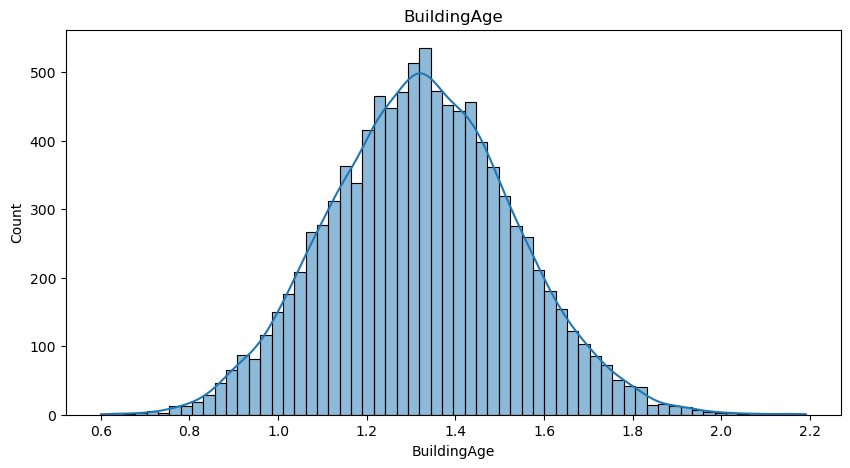

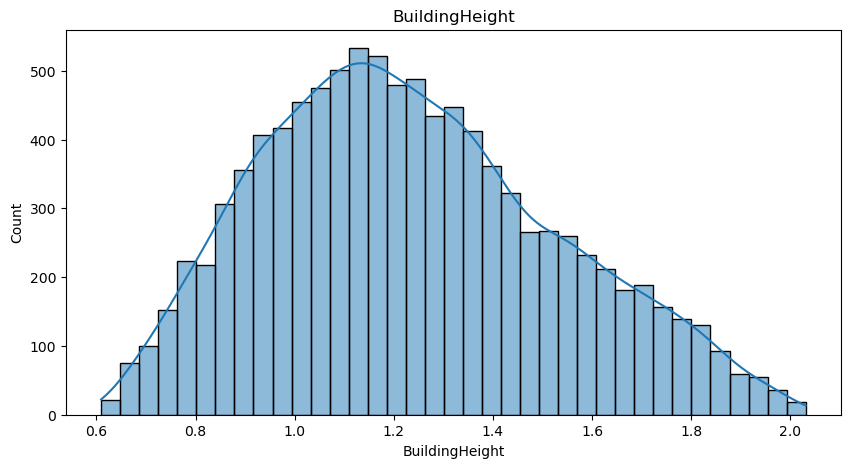

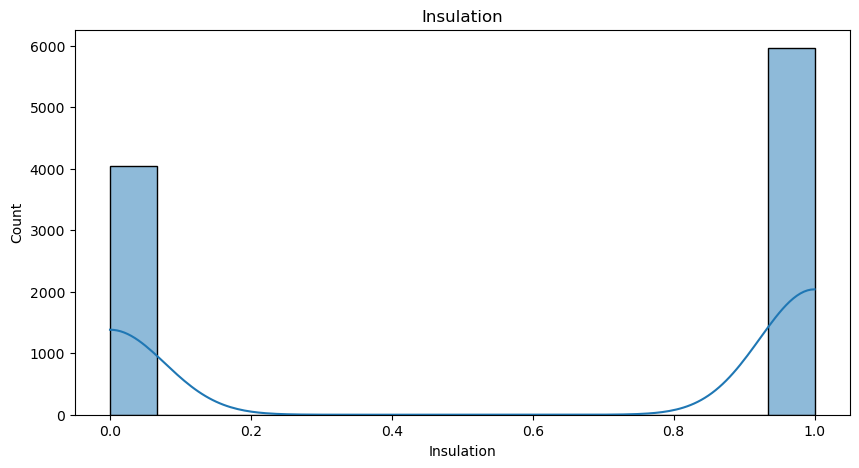

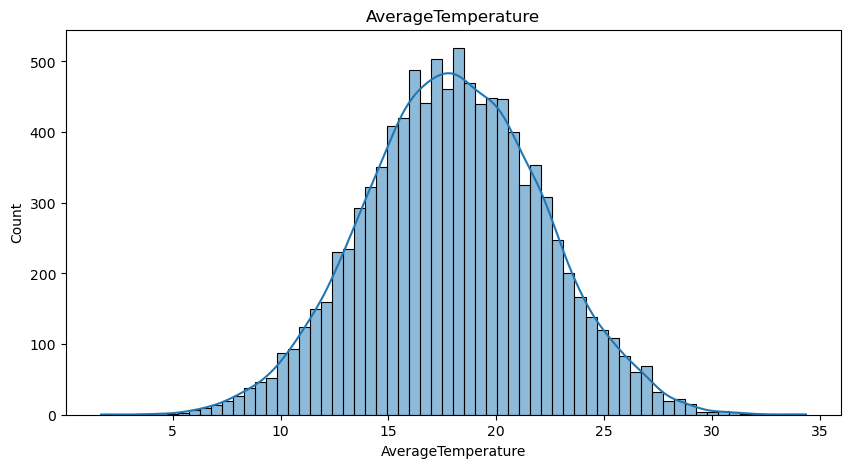

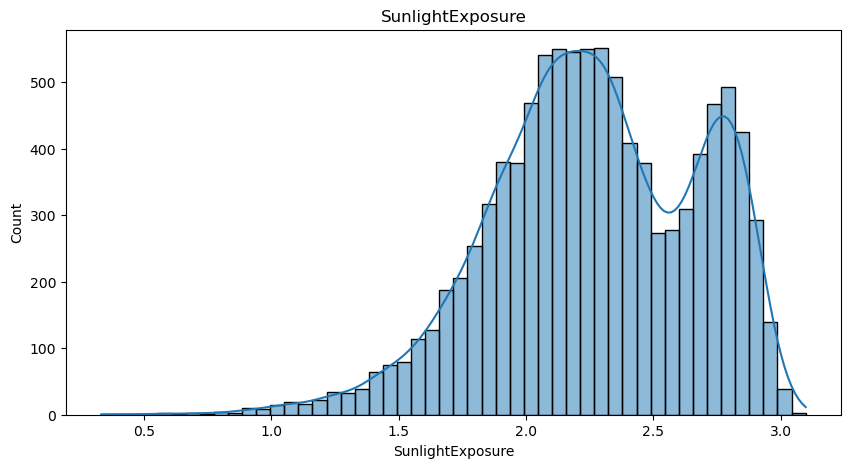

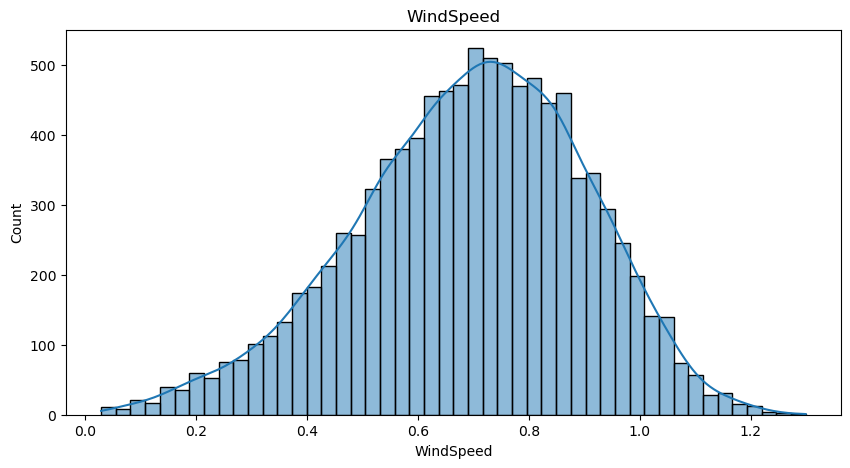

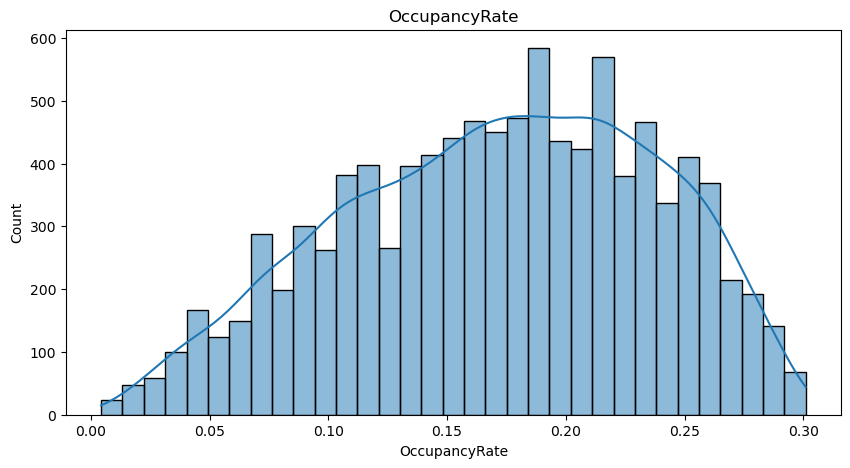

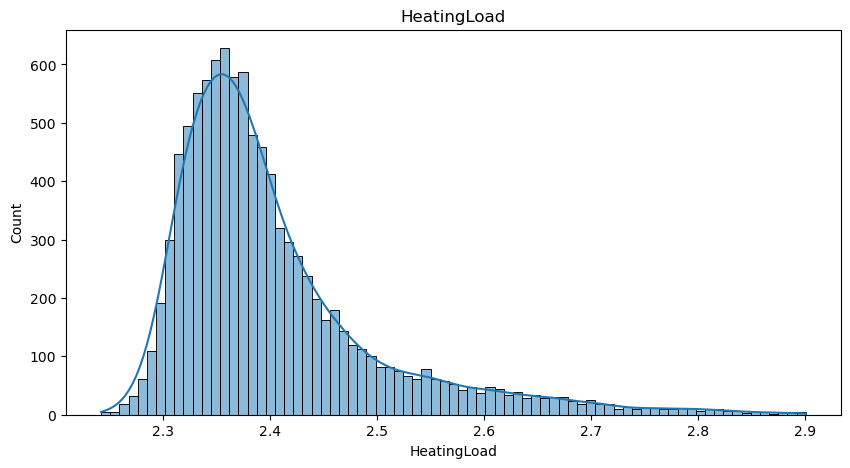

In [13]:
# Create a histogram of the variables with bell shaped distribution
for i in log_transformed_heat_load_training_data.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(log_transformed_heat_load_training_data[i], kde=True)
    plt.title(i)
    plt.show()

### QQ-plot

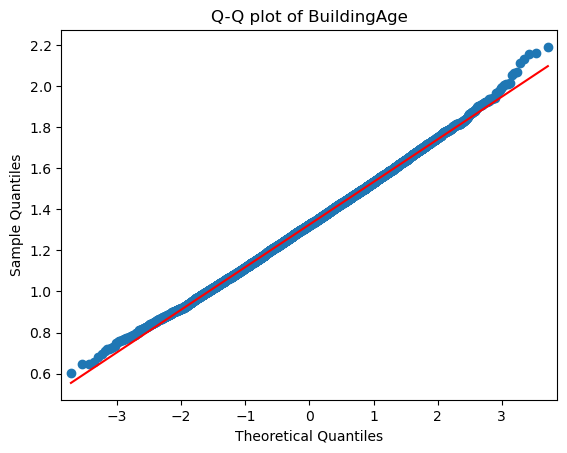

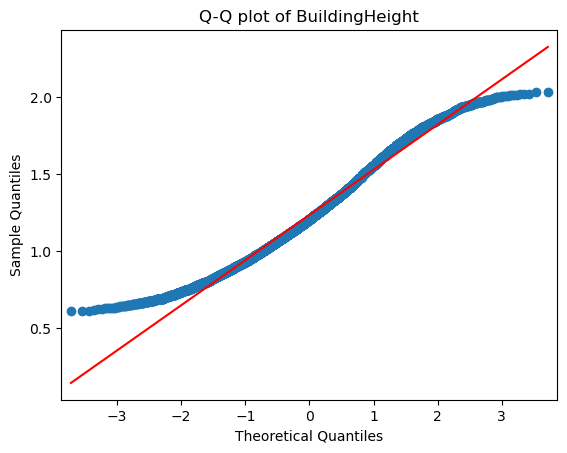

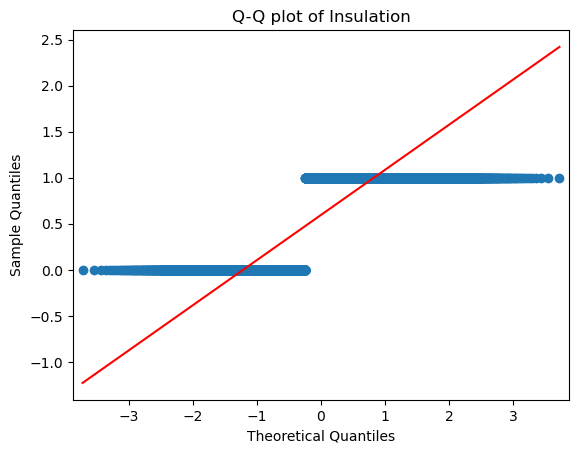

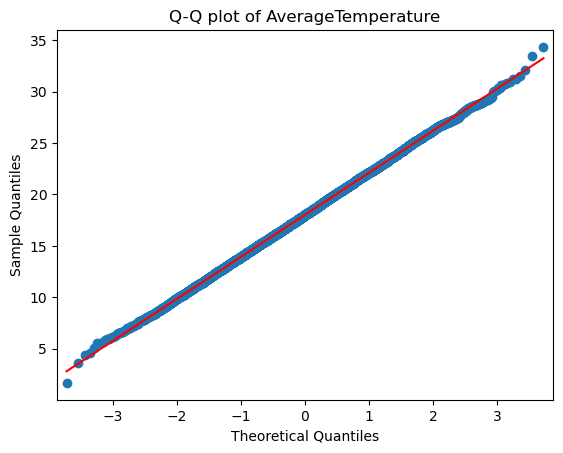

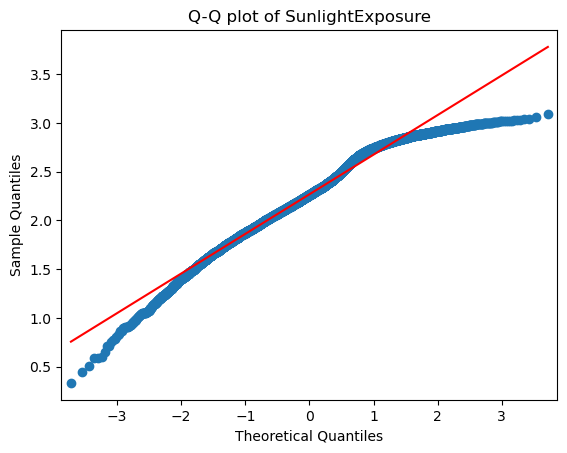

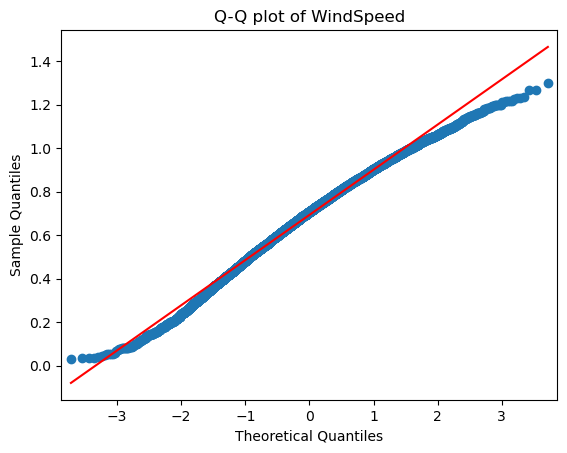

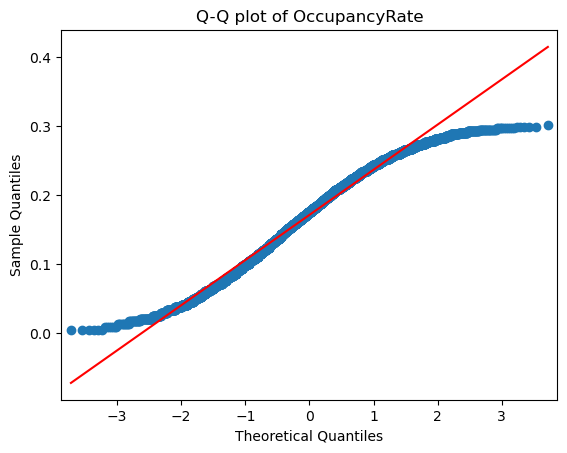

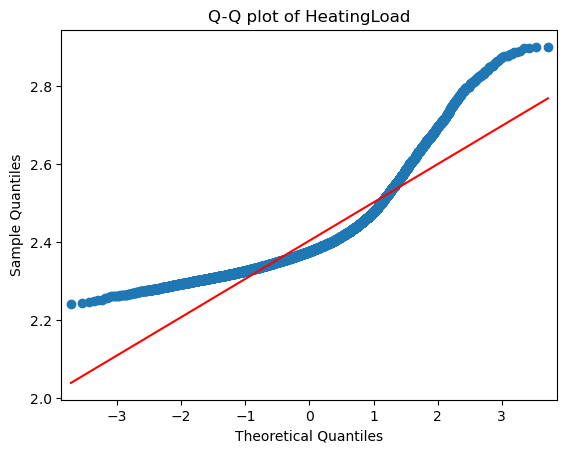

In [14]:
for i in log_transformed_heat_load_training_data.columns:
    sm.qqplot(log_transformed_heat_load_training_data[i], line='s')
    plt.title(f'Q-Q plot of {i}')
    plt.show()

## Data Normalisation

In [15]:
normalised_heating_load_training_data = preprocessing.normalize(
    log_transformed_heat_load_training_data)
scaled_heating_load_training_data = pd.DataFrame(normalised_heating_load_training_data,
                                                 columns=log_transformed_heat_load_training_data.columns)
# print(scaled_heating_load_training_data)
scaled_heating_load_training_data.head()

,BuildingAge,BuildingHeight,Insulation,AverageTemperature,SunlightExposure,WindSpeed,OccupancyRate,HeatingLoad
0,0.089644,0.103875,0.069418,0.954493,0.184491,0.047850,0.015097,0.169539
1,0.061519,0.053958,0.000000,0.982548,0.112739,0.015239,0.010001,0.121909
2,0.084333,0.052249,0.053590,0.976942,0.122278,0.040548,0.010350,0.127150
3,0.062117,0.058094,0.044871,0.982223,0.112049,0.043892,0.004348,0.107195
4,0.055599,0.056165,0.000000,0.984166,0.104720,0.020700,0.010031,0.116941


## Correlation Analysis

In [16]:
correlations_heating_load_training_data = scaled_heating_load_training_data.corr()

### Heatmap of the correlations 

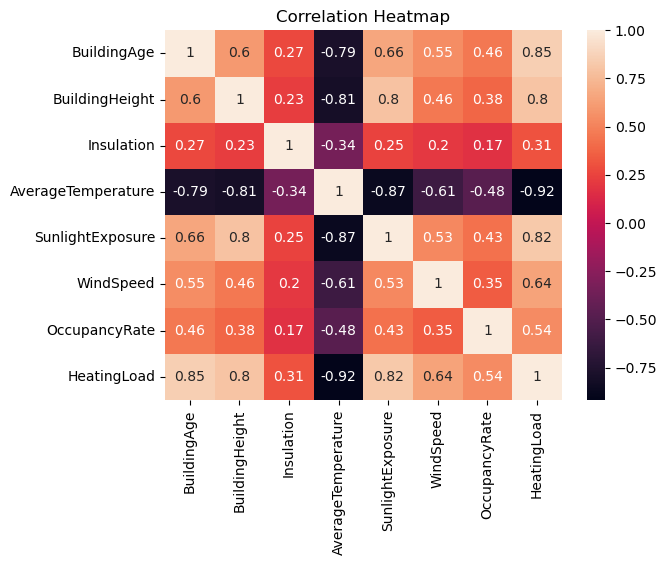

In [17]:
sns.heatmap(correlations_heating_load_training_data, annot=True)
plt.title('Correlation Heatmap')
plt.show()

### Scatterplot of the correlation 

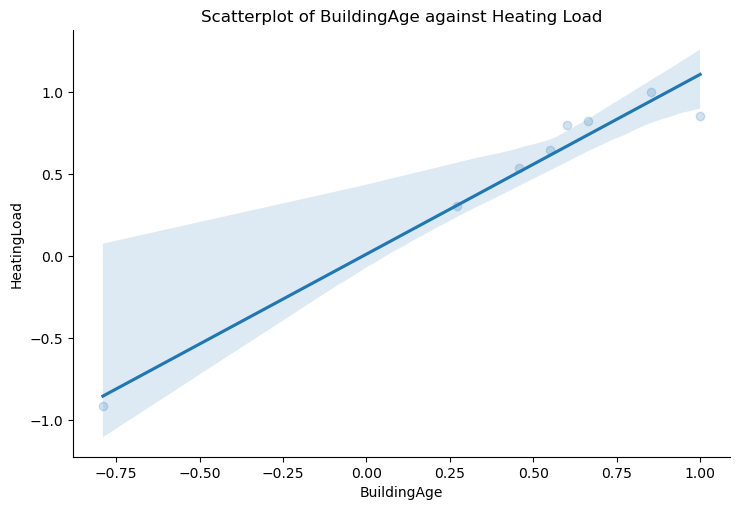

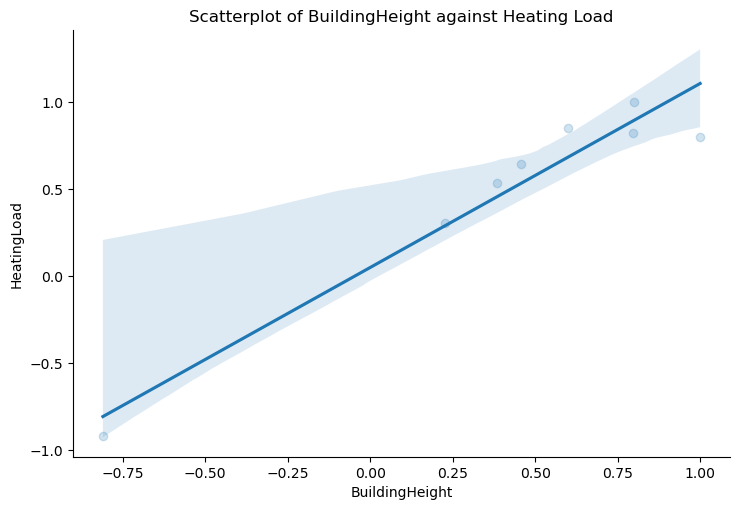

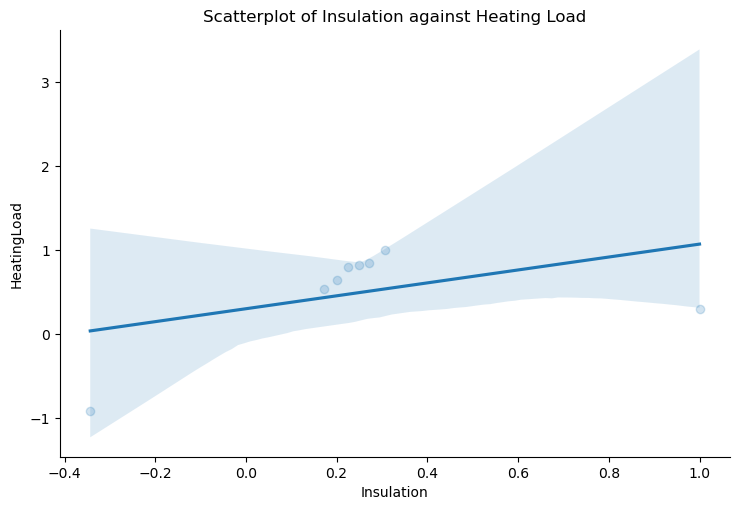

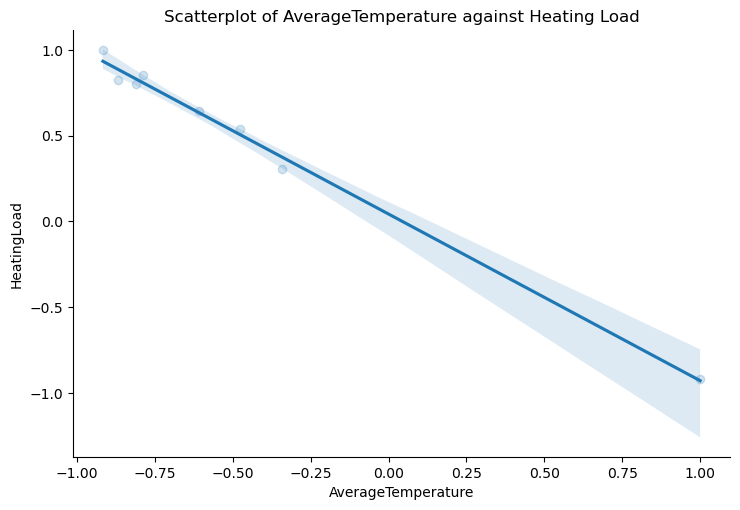

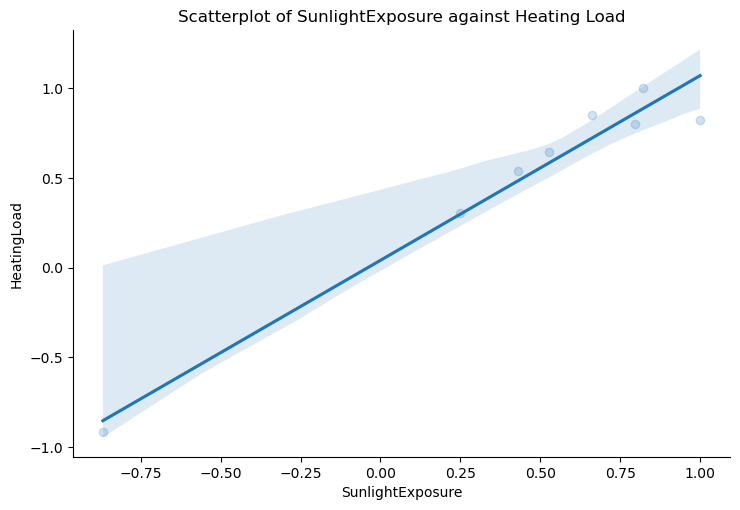

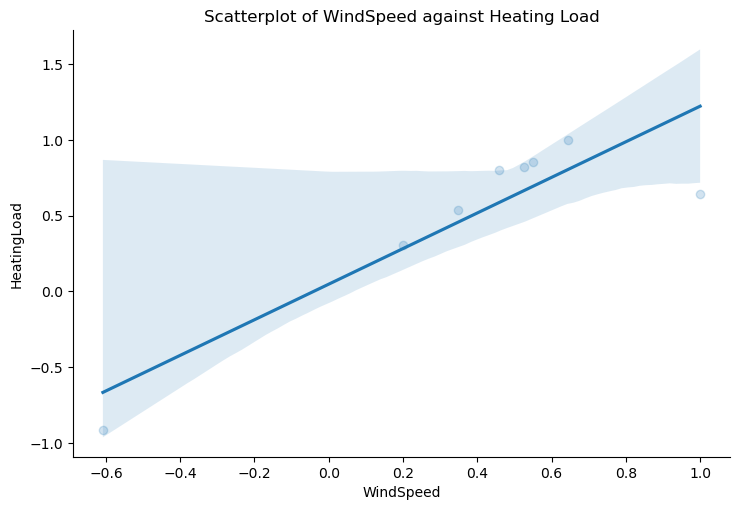

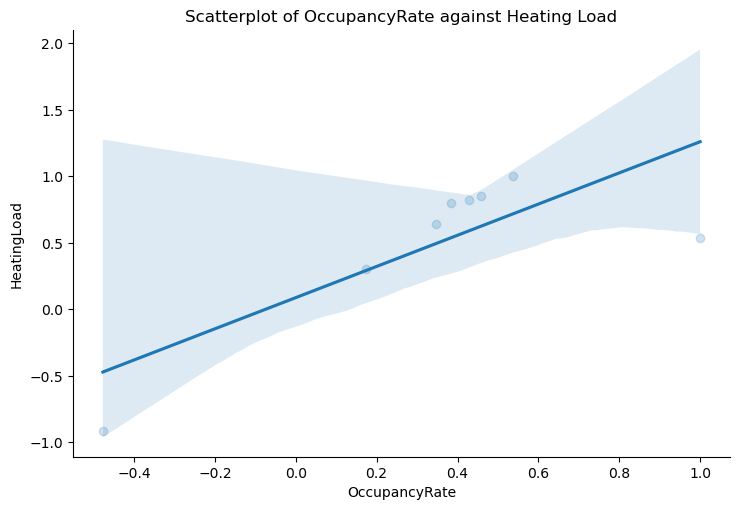

In [18]:
for column in heating_load_training_data.columns:
    if column != 'HeatingLoad':
        sns.lmplot(x=column, y='HeatingLoad', data=correlations_heating_load_training_data,
                   aspect=1.5, scatter_kws={'alpha': 0.2})
        plt.title('Scatterplot of ' + column + ' against Heating Load')
        plt.show()

# Variable Selection and Model Selection

# Code Chunk to run Unseen Dataset

In [19]:
# import pandas as pd
# HeatingLoad_test = pd. read_csv(" HeatingLoad_test .csv ")
# test_error = []
# # YOUR CODE HERE : code that produces the test error test_error
# print(test_error)